# 07. 나이브 베이즈 : 스팸 여부 판단하기

나이브 베이즈는 베이즈 정리를 적용한 조건부 확률 기반의 분류 모델
- 최근에는 딥러닝 같은 대안이 있어서 나이브 베이즈 모델을 쓰고자 하는 상황이 많지는 않음
- 스팸 메일 필터처럼 자연어 처리가 목적일 때는 선택이 될 수는 있음

딥러닝을 제외하면 자연어 처리에 가장 적합한 알고리즘
- 장점
    - 비교적 간단한 알고리즘에 속하며 속도 또한 빠름
    - 작은 훈련셋으로도 잘 예측
- 단점
    - 모든 독리변수가 각각 독립적임을 전제로 함
    - 실제 데이터에서 그런 경우가 많지 않음

유용한 곳
- 각 독립변수들이 모두 독립적이고 그 중요도가 비슷할 때 유용
- 자연어 처리에서 간단하지만 좋은 성능을 보여줌
- 범주 형태의 변수가 많을 때 적합하며, 숫자형 변수가 많은 때는 적합하지 않음

## 7.1 문제 정의: 한눈에 보는 예측 목표

문자 데이터셋을 이용해 스팸 여부를 판단
- 종속변수: target(스팸 여부)
- 평가지표: 정확도, 혼동 행렬

## 7.2 라이브러리 및 데이터 불러오기 & 데이터 확인

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_url = 'https://media.githubusercontent.com/media/musthave-ML10/data_source/main/spam.csv'
data=pd.read_csv(file_url)

In [2]:
data.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
data['target'].unique()

array(['ham', 'spam'], dtype=object)

`spam`: 스팸 문자, `ham`: 스팸이 아닌 문자

## 7.3 전처리: 특수 기호 제거하기

자연어를 다룰 때 데이터의 기준은 단어이므로 특수 기호는 노이즈가 되어 제거해야함

In [4]:
import string

string.punctuation # 특수 기호 목록 출력

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
sample_string = data['text'].loc[0]
sample_string

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [6]:
for i in sample_string:
    print(i)

G
o
 
u
n
t
i
l
 
j
u
r
o
n
g
 
p
o
i
n
t
,
 
c
r
a
z
y
.
.
 
A
v
a
i
l
a
b
l
e
 
o
n
l
y
 
i
n
 
b
u
g
i
s
 
n
 
g
r
e
a
t
 
w
o
r
l
d
 
l
a
 
e
 
b
u
f
f
e
t
.
.
.
 
C
i
n
e
 
t
h
e
r
e
 
g
o
t
 
a
m
o
r
e
 
w
a
t
.
.
.


In [7]:
# 특수 기호가 아니면 문자열 하나씩 출력
for i in sample_string:
    if i not in string.punctuation:
        print(i)

G
o
 
u
n
t
i
l
 
j
u
r
o
n
g
 
p
o
i
n
t
 
c
r
a
z
y
 
A
v
a
i
l
a
b
l
e
 
o
n
l
y
 
i
n
 
b
u
g
i
s
 
n
 
g
r
e
a
t
 
w
o
r
l
d
 
l
a
 
e
 
b
u
f
f
e
t
 
C
i
n
e
 
t
h
e
r
e
 
g
o
t
 
a
m
o
r
e
 
w
a
t


In [8]:
new_string=[]
for i in sample_string:
    if i not in string.punctuation:
        new_string.append(i)

In [9]:
new_string

['G',
 'o',
 ' ',
 'u',
 'n',
 't',
 'i',
 'l',
 ' ',
 'j',
 'u',
 'r',
 'o',
 'n',
 'g',
 ' ',
 'p',
 'o',
 'i',
 'n',
 't',
 ' ',
 'c',
 'r',
 'a',
 'z',
 'y',
 ' ',
 'A',
 'v',
 'a',
 'i',
 'l',
 'a',
 'b',
 'l',
 'e',
 ' ',
 'o',
 'n',
 'l',
 'y',
 ' ',
 'i',
 'n',
 ' ',
 'b',
 'u',
 'g',
 'i',
 's',
 ' ',
 'n',
 ' ',
 'g',
 'r',
 'e',
 'a',
 't',
 ' ',
 'w',
 'o',
 'r',
 'l',
 'd',
 ' ',
 'l',
 'a',
 ' ',
 'e',
 ' ',
 'b',
 'u',
 'f',
 'f',
 'e',
 't',
 ' ',
 'C',
 'i',
 'n',
 'e',
 ' ',
 't',
 'h',
 'e',
 'r',
 'e',
 ' ',
 'g',
 'o',
 't',
 ' ',
 'a',
 'm',
 'o',
 'r',
 'e',
 ' ',
 'w',
 'a',
 't']

In [10]:
new_string=''.join(new_string)

In [11]:
def remove_punc(x): # 특수 기호 삭제 함수
    new_string=[]
    for i in x:
        if i not in string.punctuation:
            new_string.append(i)
    new_string=''.join(new_string)
    return new_string

In [12]:
remove_punc(sample_string)

'Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amore wat'

In [13]:
remove_punc(data['text'])

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...Ok lar... Joking wif u oni...Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C\'s apply 08452810075over18\'sU dun say so early hor... U c already then say...Nah I don\'t think he goes to usf, he lives around here thoughFreeMsg Hey there darling it\'s been 3 week\'s now and no word back! I\'d like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcvEven my brother is not like to speak with me. They treat me like aids patent.As per your request \'Melle Melle (Oru Minnaminunginte Nurungu Vettam)\' has been set as your callertune for all Callers. Press *9 to copy your friends CallertuneWINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.Had your mobile 11 months or more? U R entitl

한 행에 모든 문자열이 합쳐진 형태로 보임

In [14]:
data['text'].apply(remove_punc)

0       Go until jurong point crazy Available only in ...
1                                 Ok lar Joking wif u oni
2       Free entry in 2 a wkly comp to win FA Cup fina...
3             U dun say so early hor U c already then say
4       Nah I dont think he goes to usf he lives aroun...
                              ...                        
5569    This is the 2nd time we have tried 2 contact u...
5570                  Will ü b going to esplanade fr home
5571    Pity  was in mood for that Soany other suggest...
5572    The guy did some bitching but I acted like id ...
5573                            Rofl Its true to its name
Name: text, Length: 5574, dtype: object

In [15]:
data['text']=data['text'].apply(remove_punc)

## 7.4 전처리: 불용어 제거하기

`불용어`: 자연어 분석에 큰 도움이 안되는 단어
- 분석 목적에 따라 불용어가 달라짐

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\boo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [17]:
from nltk.corpus import stopwords

stopwords.words('english')

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

- english는 영어 불용어 지정
- nltk는 한국어 불용어가 제공되지않아 korea를 넣어도 안됨

In [18]:
sample_string = data['text'].loc[0]
sample_string.split()

['Go',
 'until',
 'jurong',
 'point',
 'crazy',
 'Available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'Cine',
 'there',
 'got',
 'amore',
 'wat']

In [19]:
for i in sample_string.split():
    if i not in stopwords.words('english'):
        print(i)

Go
jurong
point
crazy
Available
bugis
n
great
world
la
e
buffet
Cine
got
amore
wat


파이썬은 대소문자를 구분하기에 대문자를 모두 소문자로 변경

In [20]:
for i in sample_string.split():
    if i.lower() not in stopwords.words('english'):
        print(i.lower())

go
jurong
point
crazy
available
bugis
n
great
world
la
e
buffet
cine
got
amore
wat


In [24]:
new_string=[]
for i in sample_string.split():
    if i.lower() not in stopwords.words('english'):
        new_string.append(i.lower())
        
new_string = ' '.join(new_string) # 공백 단위로 묶기

new_string

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

In [25]:
def stop_words(x):
    new_string=[]
    for i in x.split():
        if i.lower() not in stopwords.words('english'):
            new_string.append(i.lower())
    new_string = ' '.join(new_string)
    return new_string

data['text']=data['text'].apply(stop_words)
data['text']

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                     u dun say early hor u c already say
4             nah dont think goes usf lives around though
                              ...                        
5569    2nd time tried 2 contact u u £750 pound prize ...
5570                          ü b going esplanade fr home
5571                          pity mood soany suggestions
5572    guy bitching acted like id interested buying s...
5573                                       rofl true name
Name: text, Length: 5574, dtype: object

## 7.5 전처리: 목표 컬럼 형태 변경하기

스팸이면 1, 아니면 0으로 변환

In [26]:
data['target'] = data['target'].map({'spam':1, 'ham':0})
data['target']

0       0
1       0
2       1
3       0
4       0
       ..
5569    1
5570    0
5571    0
5572    0
5573    0
Name: target, Length: 5574, dtype: int64

## 7.6 전처리: 카운트 기반으로 벡터화하기

`카운트 기반 벡터화`: 문자를 개수 기반으로 벡터화하는 방식
- 데이터 전체에 존재하는 모든 단어들을 사전처럼 모은 뒤에 인덱스를 부여하고, 카운트하는 것

In [27]:
x=data['text']
y=data['target']

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer()
cv.fit(x)
cv.vocabulary_ # 객체에 들어 있는 단어의 인덱스 확인

{'go': 3791,
 'jurong': 4687,
 'point': 6433,
 'crazy': 2497,
 'available': 1414,
 'bugis': 1881,
 'great': 3888,
 'world': 9184,
 'la': 4847,
 'buffet': 1879,
 'cine': 2214,
 'got': 3848,
 'amore': 1181,
 'wat': 8947,
 'ok': 5995,
 'lar': 4886,
 'joking': 4655,
 'wif': 9079,
 'oni': 6027,
 'free': 3577,
 'entry': 3160,
 'wkly': 9136,
 'comp': 2330,
 'win': 9093,
 'fa': 3296,
 'cup': 2553,
 'final': 3421,
 'tkts': 8380,
 '21st': 454,
 'may': 5335,
 '2005': 441,
 'text': 8217,
 '87121': 875,
 'receive': 6833,
 'questionstd': 6724,
 'txt': 8592,
 'ratetcs': 6776,
 'apply': 1267,
 '08452810075over18s': 71,
 'dun': 3011,
 'say': 7192,
 'early': 3031,
 'hor': 4222,
 'already': 1154,
 'nah': 5682,
 'dont': 2918,
 'think': 8291,
 'goes': 3805,
 'usf': 8741,
 'lives': 5050,
 'around': 1318,
 'though': 8310,
 'freemsg': 3585,
 'hey': 4118,
 'darling': 2617,
 'weeks': 9002,
 'word': 9170,
 'back': 1464,
 'id': 4343,
 'like': 5000,
 'fun': 3652,
 'still': 7860,
 'tb': 8147,
 'xxx': 9309,
 'std': 

In [29]:
x = cv.transform(x)
print(x)

  (0, 1181)	1
  (0, 1414)	1
  (0, 1879)	1
  (0, 1881)	1
  (0, 2214)	1
  (0, 2497)	1
  (0, 3791)	1
  (0, 3848)	1
  (0, 3888)	1
  (0, 4687)	1
  (0, 4847)	1
  (0, 6433)	1
  (0, 8947)	1
  (0, 9184)	1
  (1, 4655)	1
  (1, 4886)	1
  (1, 5995)	1
  (1, 6027)	1
  (1, 9079)	1
  (2, 71)	1
  (2, 441)	1
  (2, 454)	1
  (2, 875)	1
  (2, 1267)	1
  (2, 2330)	1
  :	:
  (5570, 3188)	1
  (5570, 3564)	1
  (5570, 3810)	1
  (5570, 4188)	1
  (5571, 5566)	1
  (5571, 6359)	1
  (5571, 7611)	1
  (5571, 7986)	1
  (5572, 999)	1
  (5572, 1665)	1
  (5572, 1916)	1
  (5572, 3103)	1
  (5572, 3577)	1
  (5572, 3701)	1
  (5572, 3950)	1
  (5572, 4343)	1
  (5572, 4480)	1
  (5572, 5000)	1
  (5572, 5777)	1
  (5572, 7636)	1
  (5572, 8731)	1
  (5572, 8997)	1
  (5573, 5688)	1
  (5573, 7052)	1
  (5573, 8538)	1


(`데이터의 행 번호`, `단어의 인덱스값`) `행에서 출연 횟수`

In [30]:
data.loc[0]['text']

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

In [32]:
print(cv.vocabulary_['go'])
print(cv.vocabulary_['jurong'])
print(cv.vocabulary_['point'])

3791
4687
6433


## 7.7 모델링 및 예측/ 평가하기

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

In [35]:
from sklearn.naive_bayes import MultinomialNB #다항분포에 대한 naive Bases

# 가우시안과 베이지안 모델도 있음

In [36]:
model = MultinomialNB()
model.fit(x_train, y_train)
pred = model.predict(x_test)

`confusion_matrix`: 혼동 행렬
- 예측값과 실제값을 비교한 4가지 결과를 확인할 수 있음

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_score(y_test, pred)

0.9856502242152466

In [38]:
print(confusion_matrix(y_test, pred))

[[965  12]
 [  4 134]]


- 1) 실젯값이 0이고 예측값도 0인 경우: 965건
- 2) 실젯값이 0이고 예측값이 1인 경우: 12건
- 3) 실젯값이 1이고 예측값이 0인 경우: 4건
- 4) 실젯값이 1이고 예측값도 1인 경우: 134건

1,4 번이 잘 예측한 경우이고, 2,3 번이 잘못 예측한 경우임

<AxesSubplot:>

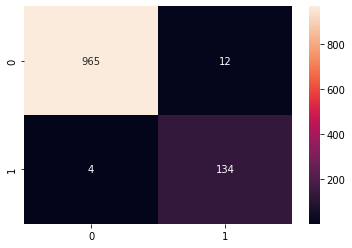

In [39]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='.0f')

정확도 = 잘 예측한 경우의 수 / 전체 경우의 수

- `제 1종 오류(Type 1 Error)` : 실제 음성인 것을 양성으로 예측하는 오류(FP)(= $\alpha$)
- `제 2종 오류(Type 2 Error)` : 실제 양성인 것을 음성으로 예측하는 오류(FN)(= $\beta$)

# 08. 결정트리: 연봉 예측하기

결정 트리는 관측값과 목푯값을 연결시켜주는 예측 모델
- 수많은 트리 기반 모델의 기본 모델

트리 모델은 선형 모델과 다른 특징을 가짐
- 선형 모델: 각 변수에 대한 기울기값들을 최적화하여 모델을 만듬
- 트리 모델: 각 변수의 특정 지점을 기준으로 데이터를 분류해가며 예측 모델을 만듬

예측력과 성능만을 따지면 결정 트리를 사용할 일이 없지만, 앞으로 다른 트리 기반 모델을 설명하려면 결정 트리를 알아야함

`예측력`: 모델 학습을 통해 얼마나 좋은 예측치를 보여주는가를 의미

`설명력`: 학습된 모델을 얼마나 쉽게 해석할 수 있는지를 의미

- 알고리즘의 복잡도가 증가할수록 예측력은 좋아지나 설명력은 다소 떨어지는 반비례 관계를 보여줌

- 장점
    - 데이터에 대한 가정이 없는 모델 -> 자유롭게 적용 가능
    - 아웃라이어에 영향을 거의 받지 않음
    - 트리 그래프를 통해서 직관적으로 이해하고 설명할 수 있음
- 단점
    - 트리가 무한정 깊어지면 오버피팅 문제를 야기할 수 있음
    - 앞으로 배울 발전된 트리 기반 모델들에 비하면 예측력이 상당히 떨어짐
- 유용한 곳
    - 종속변수가 연속형 데이터와 범주형 데이터 모두에 사용할 수 있음
    - 모델링 결과를 시각화할 목적으로 가장 유용
    - 아웃라이어가 문제될 정도로 많을 때 선형 모델보다 좋은 대안이 될 수 있음

## 8.1 문제 정의: 한눈에 보는 예측 목표

- 종속변수: class(연봉 등급)
- 평가지표: 정확도

## 8.2 라이브러리 및 데이터 불러오기, 데이터 확인하기

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_url = 'https://media.githubusercontent.com/media/musthave-ML10/data_source/main/salary.csv'
data = pd.read_csv(file_url, skipinitialspace = True)

In [44]:
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


- age: 연령
- workclass: 고용 형태
- education: 학력
- education-num: 교육 연수
- marital-status: 혼인상태
- occupation: 직업
- relationship: 가족 관계
- race: 인종
- sex: 성별
- capital-gain: 자산 증가
- capital-loss: 자산 감소
- hours-per-week: 주당 노동 시간
- native-country: 본국
- class: 연봉 구분

In [45]:
data['class'].unique()

array(['<=50K', '>50K'], dtype=object)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   education       48842 non-null  object
 3   education-num   48842 non-null  int64 
 4   marital-status  48842 non-null  object
 5   occupation      46033 non-null  object
 6   relationship    48842 non-null  object
 7   race            48842 non-null  object
 8   sex             48842 non-null  object
 9   capital-gain    48842 non-null  int64 
 10  capital-loss    48842 non-null  int64 
 11  hours-per-week  48842 non-null  int64 
 12  native-country  47985 non-null  object
 13  class           48842 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.2+ MB


In [47]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382
std,13.710510,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [48]:
data.describe(include='all')

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
count,48842.000000,46043,48842,48842.000000,48842,46033,48842,48842,48842,48842.000000,48842.000000,48842.000000,47985,48842
unique,NaN,8,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,33906,15784,NaN,22379,6172,19716,41762,32650,NaN,NaN,NaN,43832,37155
mean,38.643585,NaN,NaN,10.078089,NaN,NaN,NaN,NaN,NaN,1079.067626,87.502314,40.422382,NaN,NaN
std,13.710510,NaN,NaN,2.570973,NaN,NaN,NaN,NaN,NaN,7452.019058,403.004552,12.391444,NaN,NaN
min,17.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


## 8.3 전처리: 범주형 데이터

In [49]:
data['class'] = data['class'].map({'<=50K':0, '>50K':1})

In [50]:
data['age'].dtype

dtype('int64')

In [51]:
for i in data.columns:
    print(i, data[i].dtype)

age int64
workclass object
education object
education-num int64
marital-status object
occupation object
relationship object
race object
sex object
capital-gain int64
capital-loss int64
hours-per-week int64
native-country object
class int64


object형 확인 가능

In [52]:
# object일 경우 list에 추가
obj_list = []
for i in data.columns:
    if data[i].dtype=='object':
        obj_list.append(i)

In [53]:
obj_list

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [54]:
# 각 column의 고유값 개수 확인
for i in obj_list:
    print(i, data[i].nunique())

workclass 8
education 16
marital-status 7
occupation 14
relationship 6
race 5
sex 2
native-country 41


In [55]:
for i in obj_list:
    if data[i].nunique() >= 10:
        print(i, data[i].nunique())

education 16
occupation 14
native-country 41


In [56]:
# education 고유값의 빈도 확인
data['education'].value_counts()

HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64

미국의 교육 시스템
- 초중고:1~12학년
- Bacherlors, Masters, ...
- 순서화 가능

In [57]:
np.sort(data['education-num'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

education-num으로 이미 서열화가 되어있음

In [58]:
data['education-num']==1

0        False
1        False
2        False
3        False
4        False
         ...  
48837    False
48838    False
48839    False
48840    False
48841    False
Name: education-num, Length: 48842, dtype: bool

In [59]:
data[data['education-num']==1]

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
779,64,Private,Preschool,1,Married-civ-spouse,Handlers-cleaners,Husband,Asian-Pac-Islander,Male,0,0,40,Philippines,0
818,21,Private,Preschool,1,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,25,Mexico,0
1029,57,NaN,Preschool,1,Separated,NaN,Not-in-family,White,Male,0,0,40,United-States,0
1059,31,Private,Preschool,1,Never-married,Handlers-cleaners,Not-in-family,Amer-Indian-Eskimo,Male,0,0,25,United-States,0
1489,19,Private,Preschool,1,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,36,Mexico,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48079,31,State-gov,Preschool,1,Never-married,Other-service,Not-in-family,White,Male,0,0,24,United-States,0
48316,40,Private,Preschool,1,Married-civ-spouse,Other-service,Husband,White,Male,0,1672,40,Mexico,0
48505,40,Private,Preschool,1,Never-married,Other-service,Not-in-family,White,Female,0,0,20,United-States,0
48640,46,Private,Preschool,1,Married-civ-spouse,Machine-op-inspct,Other-relative,Black,Male,0,0,75,Dominican-Republic,0


In [60]:
data[data['education-num']==1]['education'].unique()

array(['Preschool'], dtype=object)

In [61]:
data[data['education-num']==1]['education'].unique()

array(['Preschool'], dtype=object)

In [62]:
for i in np.sort(data['education-num'].unique()):
    print(i, data[data['education-num']==i]['education'].unique())

1 ['Preschool']
2 ['1st-4th']
3 ['5th-6th']
4 ['7th-8th']
5 ['9th']
6 ['10th']
7 ['11th']
8 ['12th']
9 ['HS-grad']
10 ['Some-college']
11 ['Assoc-voc']
12 ['Assoc-acdm']
13 ['Bachelors']
14 ['Masters']
15 ['Prof-school']
16 ['Doctorate']


In [63]:
data.drop('education', axis=1, inplace=True)

In [64]:
data['occupation'].value_counts()

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

비슷한 직업군으로 묶여 있고, 서열이 없어 더미 변수 처리해야함

In [65]:
data['native-country'].value_counts()

United-States                 43832
Mexico                          951
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru                             46
Ecuador                     

United-States가 압도적으로 큰 비중을 차지
- United-State와 Others로 구분 할 수 있음

다른 방식으로는 대륙별로 묶을 수 있음

이러한 방식은 묶은 그룹끼리 유사성이 있어야함

In [66]:
data.groupby('native-country').mean()

,age,education-num,capital-gain,capital-loss,hours-per-week,class
native-country,,,,,,
Cambodia,36.892857,9.392857,697.464286,194.821429,42.035714,0.321429
Canada,44.049451,10.692308,1233.505495,131.159341,40.406593,0.346154
China,41.852459,11.262295,1407.737705,170.655738,38.262295,0.295082
Columbia,39.458824,9.258824,125.364706,65.247059,39.929412,0.047059
Cuba,46.355072,9.391304,470.543478,62.717391,40.101449,0.246377
Dominican-Republic,37.970874,7.320388,1064.456311,39.029126,41.621359,0.048544
Ecuador,37.666667,9.244444,328.288889,0.000000,39.266667,0.133333
El-Salvador,33.380645,6.722581,392.761290,36.367742,36.361290,0.070968
England,40.527559,11.110236,1076.551181,108.913386,41.937008,0.370079


In [67]:
# 한눈에 보이지 않아 class 별로 정렬
data.groupby('native-country').mean().sort_values('class')

,age,education-num,capital-gain,capital-loss,hours-per-week,class
native-country,,,,,,
Holand-Netherlands,32.000000,10.000000,0.000000,2205.000000,40.000000,0.000000
Guatemala,32.090909,6.306818,167.875000,18.113636,38.715909,0.034091
Outlying-US(Guam-USVI-etc),38.826087,10.043478,0.000000,76.608696,41.347826,0.043478
Columbia,39.458824,9.258824,125.364706,65.247059,39.929412,0.047059
Dominican-Republic,37.970874,7.320388,1064.456311,39.029126,41.621359,0.048544
Mexico,33.635121,6.026288,415.954784,32.656151,40.213460,0.049422
Nicaragua,36.285714,9.000000,138.653061,69.938776,36.938776,0.061224
El-Salvador,33.380645,6.722581,392.761290,36.367742,36.361290,0.070968
Trinadad&Tobago,39.259259,8.962963,116.185185,156.518519,38.888889,0.074074


United-States의 class 평균은 0.24로 다른 그룹과 전혀 비슷하지 않아 보이기에 Others로 묶는 것은 좋지않음

class 평균이 가장 높은 France 중심으로 유럽 국가를 보면 좋지 않음이 증명됨

트리 기반 모델에서는 범주형 변수를 숫자로 치환해도 괜찮음
- value_counts()로 숫자를 부여하는 것은 유용한 변수로 활용될 수 있지만, 동수의 값이 있어 적합하지 않음

groupby()로 확인했던 class의 평균값을 넣어주는 방법도 있음
- 오버피팅의 문제가 발생할 수 있어 주의해야함

In [68]:
country_group = data.groupby('native-country').mean()['class']

In [69]:
country_group = country_group.reset_index() # 인덱스를 변수로 불러냄

In [70]:
country_group

,native-country,class
0,Cambodia,0.321429
1,Canada,0.346154
2,China,0.295082
3,Columbia,0.047059
4,Cuba,0.246377
5,Dominican-Republic,0.048544
6,Ecuador,0.133333
7,El-Salvador,0.070968
8,England,0.370079
9,France,0.421053


In [71]:
data=data.merge(country_group, on='native-country', how='left')

In [72]:
data

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class_x,class_y
0,25,Private,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0,0.243977
1,38,Private,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0,0.243977
2,28,Local-gov,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1,0.243977
3,44,Private,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1,0.243977
4,18,NaN,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,0,0.243977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0,0.243977
48838,40,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,0.243977
48839,58,Private,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,0.243977
48840,22,Private,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0,0.243977


class_x와 class_y라는 변수가 생김
- 컬럼 이름이 겹쳐 자동 변경됨

In [73]:
data.drop('native-country', axis=1, inplace=True)
data=data.rename(columns= {'class_x':'class', 'class_y': 'native-country'})

## 8.4 전처리: 결측치 처리 및 더미 변수 변환

In [74]:
data.isna().mean()

age               0.000000
workclass         0.057307
education-num     0.000000
marital-status    0.000000
occupation        0.057512
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
class             0.000000
native-country    0.017546
dtype: float64

workclass, occupation은 약 5%, native-country은 약 1.7%의 결측값 존재

In [75]:
data['native-country'] = data['native-country'].fillna(-99)

workclass와 occupation은 범주형 변수라 평균치로 해결 할 수 없음

In [76]:
data['workclass'].value_counts()

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

In [77]:
# Private가 대부분이라 Private로 채움
data['workclass'] = data['workclass'].fillna('Private')

In [78]:
data['occupation'] = data['occupation'].fillna('Unknown')

In [79]:
data=pd.get_dummies(data, drop_first=True)

## 8.5 모델링 및 평가하기

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('class', axis=1), data['class'], test_size=0.4, random_state=100)

In [82]:
from sklearn.tree import DecisionTreeClassifier

In [84]:
model=DecisionTreeClassifier()
model.fit(X_train, y_train)
pred=model.predict(X_test)

In [85]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.8137380355223423

## 8.6 이해하기: 결정 트리

### 분류 결정 트리

`지니 인덱스`
- 각 노드에 대해서 계산
- 노드가 한쪽 아이템으로 완전히 분류가 잘된 경우 지니 인덱스가 0
- 전혀 분류가 안되어서 반반이 들어 있으면 0.5
- 최댓값은 0.5, 최솟값은 0임

`교차 엔트로피`
- 순도가 높을수록 낮은 값을 보이나, 최댓값은 1까지 나올 수 있음

### 회귀 결정 트리

가장 낮은 MSE값이 나오도록 노드를 분류해감
- MAE나 Poisson 등으로 설정할 수도 있음

## 8.7 오버피팅 문제

결정 트리는 최대한 정확하게 분류해내기까지 수많은 가지를 뻗음

100%의 정확도로 분류한다고 좋은 모델이라고 할 수 없음

`오버피팅`: 예측 모델이 훈련셋을 지나치게 잘 예측한다면 새로운 데이터를 예측할 때 큰 오차를 유발할 수 있음

`언더피팅`: 모델이 충분히 학습되지 않아 훈련셋에 대해서도 좋은 예측력을 내지 못하는 상황

## 8.8 매개변수 튜닝

In [86]:
# 오버피팅  문제를 해겨라하기 위해 매개변수를 지정해줌
model=DecisionTreeClassifier()
model.fit(X_train, y_train)
train_pred=model.predict(X_train)
test_pred=model.predict(X_test)
print('Train score:', accuracy_score(y_train, train_pred), 'Test Score:', accuracy_score(y_test, test_pred))

Train score: 0.9780242279474493 Test Score: 0.8154271382504991


이 둘의 격차가 많이나 오버피팅이라고 볼 수 있음

In [87]:
model=DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)
train_pred=model.predict(X_train)
test_pred=model.predict(X_test)
print('Train score:', accuracy_score(y_train, train_pred), 'Test Score:', accuracy_score(y_test, test_pred))

Train score: 0.8540180856509129 Test Score: 0.8499769667809797


In [88]:
model=DecisionTreeClassifier(max_depth=7)
model.fit(X_train, y_train)
train_pred=model.predict(X_train)
test_pred=model.predict(X_test)
print('Train score:', accuracy_score(y_train, train_pred), 'Test Score:', accuracy_score(y_test, test_pred))

Train score: 0.8598532673605187 Test Score: 0.8541229462046374


## 8.9 트리 그래프

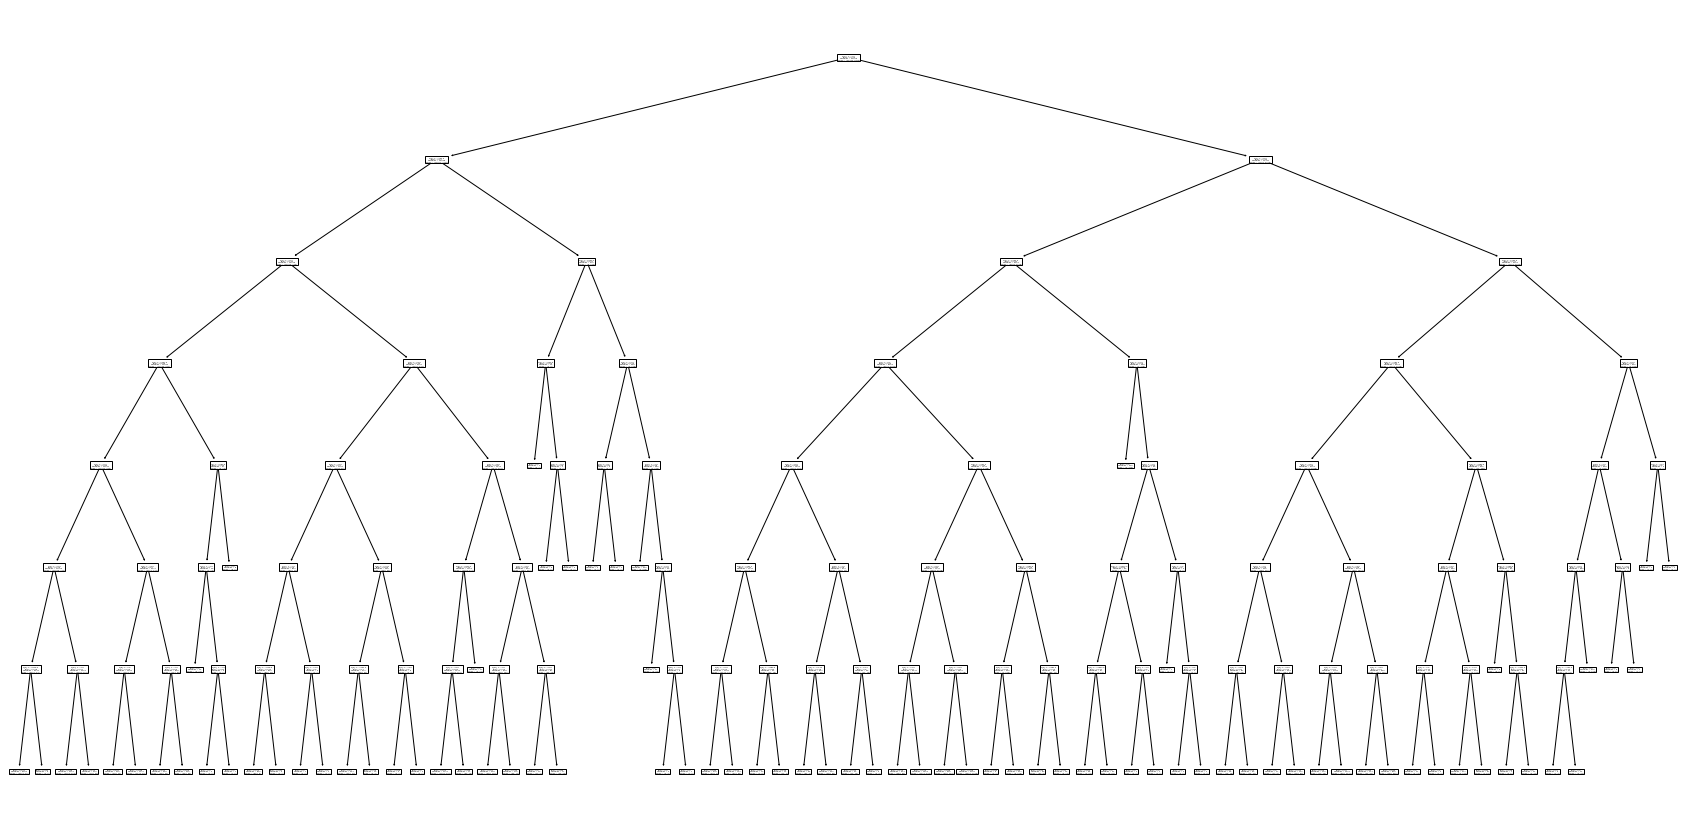

In [89]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30,15))
plot_tree(model)
plt.show()

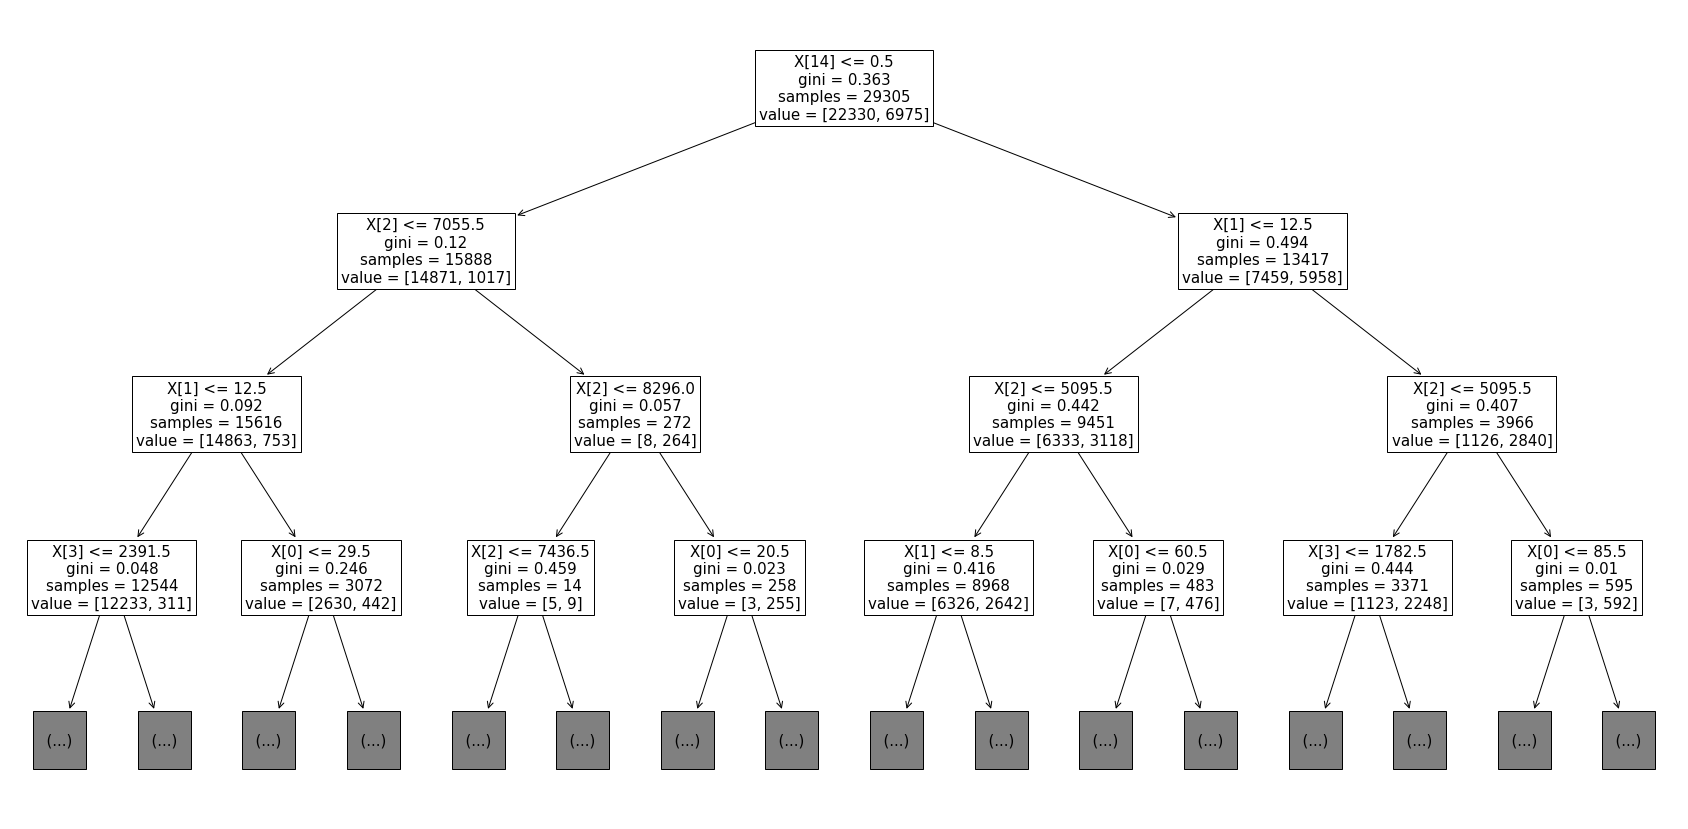

In [90]:
plt.figure(figsize=(30,15))
plot_tree(model, max_depth=3, fontsize=15)
plt.show()

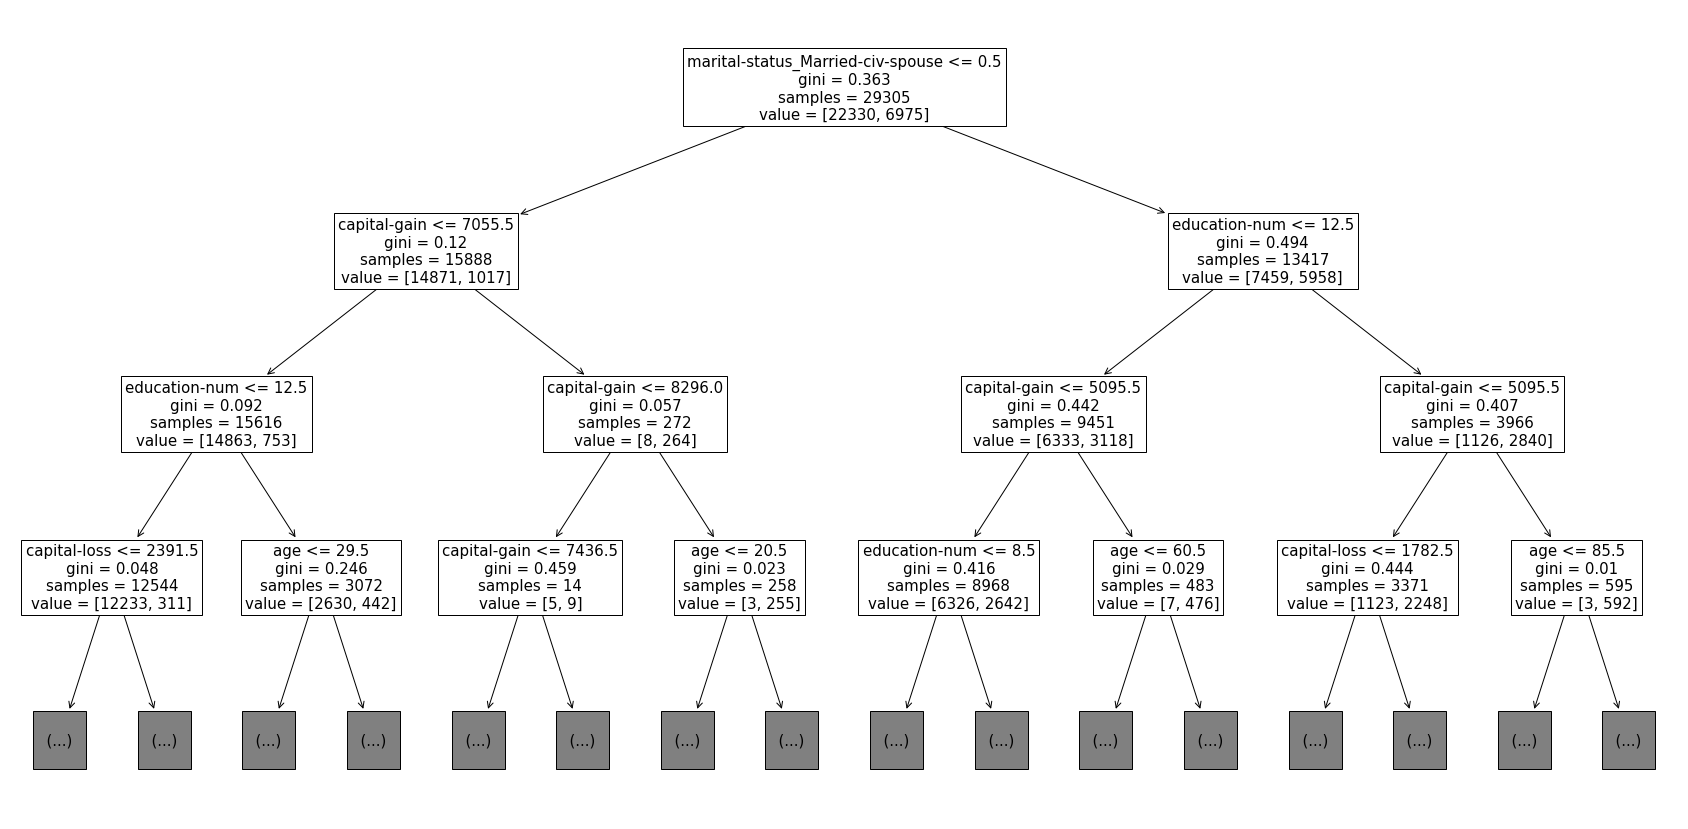

In [91]:
plt.figure(figsize=(30,15))
plot_tree(model, max_depth=3, fontsize=15, feature_names=X_train.columns)
plt.show()

# 09. 랜덤 포레스트: 중고차 가격 예측하기

결정 트리의 단점인 오버피팅 문제를 완화시켜주는 발전된 형태의 트리 모델
- 랜덤으로 생성된 무수히 많은 트리를 이용하여 예측을 하기 때문에 랜덤 포레스트라 불림

앙상블 기법을 사용한 트리 기반 모델 중 가장 보편적인 방법
- 부스팅 모델에 비해 예측력이나 속도에서 부족한 부분이 있음
- 시각화에서는 결정트리에 못 미침
- 하지만, 부스팅 모델을 이해하기 위해 필수적인 알고리즘

장점
- 결정 트리와 마찬가지로, 아웃라이어에 거의 영향을 받지 않음
- 선형/ 비선형 데이터에 상관없이 잘 작동

단점
- 학습 속도가 상대적으로 느림
- 수많은 트리를 동원하기 때문에 모델에 대한 해석이 어려움

유용한 곳
- 종속변수가 연속형 데이터와 범주형 데이터인 경우 모두에서 사용할 수 있음
- 아웃라이어가 문제가 되는 경우 선형 모델보다 좋은 대안이 될 수 있음
- 오버피팅 문제로 결정 트리를 사용하기 어려울 때, 랜덤 포레스트를 사용할 수 있음

## 9.1 문제 정의: 한눈에 보는 예측 목표

중고차 판매 이력 데이터셋을 이용해 중고차 가격을 예측
- 종속변수: selling_price
- 평가지표: RMSE

## 9.2 라이브러리 및 데이터 불러오기, 데이터 확인하기

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_url = 'https://media.githubusercontent.com/media/musthave-ML10/data_source/main/car.csv'
data=pd.read_csv(file_url)

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


- name: 이름
- year: 생산년
- selling_price: 판매가
- km_driven: 주행 거리
- fuel: 연료
- seller_type: 판매자 유형
- transmission: 변속기
- owner: 차주 변경 내용
- milege: 마일리지
- engine: 배기량
- max_power: 최대출력
- torque: 토크
- seats: 인승

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


결측치와 숫자형, 문자형 모두 있음
- engine은 숫자형이 적합한데 문자형으로 표기되어있음('cc'가 붙어있어서 그럼)

In [96]:
round(data.describe(),2)

,year,selling_price,km_driven,seats
count,8128.00,8128.00,8128.00,7907.00
mean,2013.80,638271.81,69819.51,5.42
std,4.04,806253.40,56550.55,0.96
min,1983.00,29999.00,1.00,2.00
25%,2011.00,254999.00,35000.00,5.00
50%,2015.00,450000.00,60000.00,5.00
75%,2017.00,675000.00,98000.00,5.00
max,2020.00,10000000.00,2360457.00,14.00


아웃라이어가 보임

## 9.3 전처리: 텍스트 데이터

In [97]:
data['engine'].str.split(expand=True) # 공백 기준으로 문자형 분할

,0,1
0,1248,CC
1,1498,CC
2,1497,CC
3,1396,CC
4,1298,CC
...,...,...
8123,1197,CC
8124,1493,CC
8125,1248,CC
8126,1396,CC


In [98]:
data[['engine','engine_unit']]= data['engine'].str.split(expand=True)

In [99]:
data['engine'].head()

0    1248
1    1498
2    1497
3    1396
4    1298
Name: engine, dtype: object

In [100]:
data['engine']=data['engine'].astype('float32')

In [101]:
data['engine'].head()

0    1248.0
1    1498.0
2    1497.0
3    1396.0
4    1298.0
Name: engine, dtype: float32

In [102]:
data['engine_unit'].unique()

array(['CC', nan], dtype=object)

In [103]:
# CC 하나의 값이므로 제거
data.drop('engine_unit', axis=1, inplace=True)

In [104]:
data[['max_power', 'max_power_unit']] = data['max_power'].str.split(expand=True)

data['max_power'].head()

0        74
1    103.52
2        78
3        90
4      88.2
Name: max_power, dtype: object

In [105]:
data['max_power']=data['max_power'].astype('float32')

ValueError: could not convert string to float: 'bhp'

bhp라는 문자형이 있어 error

In [106]:
data[data['max_power']=='bhp']

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_power_unit
4933,Maruti Omni CNG,2000,80000,100000,CNG,Individual,Manual,Second Owner,10.9 km/kg,796.0,bhp,NaN,8.0,None


In [107]:
def isFloat(value):
    try:
        num=float(value)
        return num
    except ValueError:
        return np.NaN

In [108]:
data['max_power']=data['max_power'].apply(isFloat)

In [109]:
data['max_power_unit'].unique()

array(['bhp', nan, None], dtype=object)

In [110]:
data.drop('max_power_unit', axis=1, inplace=True)

In [111]:
data[['mileage', 'mileage_unit']] = data['mileage'].str.split(expand=True)

In [112]:
data['mileage']=data['mileage'].astype('float32')

In [113]:
data['mileage_unit'].unique()

array(['kmpl', 'km/kg', nan], dtype=object)

In [114]:
data['fuel'].unique()

array(['Diesel', 'Petrol', 'LPG', 'CNG'], dtype=object)

각 연료에 대한 동일 시점 가격
- Petrol: 리터당 $80.43

- Diesel: 리터당 $73.56

- LPG: 킬로그램당 $40.85

- CNG: 킬로그램당 $44.23

In [115]:
def mile(x):
    if x['fuel']=='Petrol':
        return x['mileage']/80.43
    elif x['fuel']=='Diesel':
        return x['mileage']/73.56
    elif x['fuel']=='LPG':
        return x['mileage']/40.85
    else:
        return x['mileage']/44.23

In [116]:
data['mileage']=data.apply(mile, axis=1)

In [117]:
data.drop('mileage_unit', axis=1, inplace=True)

In [118]:
data['torque'].head()

0              190Nm@ 2000rpm
1         250Nm@ 1500-2500rpm
2       12.7@ 2,700(kgm@ rpm)
3    22.4 kgm at 1750-2750rpm
4       11.5@ 4,500(kgm@ rpm)
Name: torque, dtype: object

In [119]:
# nm과 kgm 부분만 다룸
data['torque']=data['torque'].str.upper()

In [120]:
def torque_unit(x):
    if 'NM' in str(x):
        return 'Nm'
    elif 'KGM' in str(x):
        return 'kgm'

In [122]:
data['torque_unit']=data['torque'].apply(torque_unit)

In [123]:
data['torque_unit'].unique()

array(['Nm', 'kgm', None], dtype=object)

In [124]:
data['torque_unit'].isna()
data[data['torque_unit'].isna()]
data[data['torque_unit'].isna()]['torque'].unique()

array([nan, '250@ 1250-5000RPM', '510@ 1600-2400', '110(11.2)@ 4800',
       '210 / 1900'], dtype=object)

In [125]:
data['torque_unit'].fillna('Nm', inplace=True)

In [126]:
string_example='12.7@ 2,700(KGM@ RPM)'

In [127]:
string_example[:4]

'12.7'

In [129]:
for i,j in enumerate(string_example):
    print(i, '번째 텍스트: ', j)

0 번째 텍스트:  1
1 번째 텍스트:  2
2 번째 텍스트:  .
3 번째 텍스트:  7
4 번째 텍스트:  @
5 번째 텍스트:   
6 번째 텍스트:  2
7 번째 텍스트:  ,
8 번째 텍스트:  7
9 번째 텍스트:  0
10 번째 텍스트:  0
11 번째 텍스트:  (
12 번째 텍스트:  K
13 번째 텍스트:  G
14 번째 텍스트:  M
15 번째 텍스트:  @
16 번째 텍스트:   
17 번째 텍스트:  R
18 번째 텍스트:  P
19 번째 텍스트:  M
20 번째 텍스트:  )


In [130]:
for i,j in enumerate(string_example):
    if j not in '0123456789.':
        cut=i
        break

In [131]:
def split_num(x):
    x=str(x)
    for i,j in enumerate(x):
        if j not in '0123456789.':
            cut=i
            break
    return x[:cut]

In [132]:
data['torque']=data['torque'].apply(split_num)

In [133]:
data['torque']

0         190
1         250
2        12.7
3        22.4
4        11.5
        ...  
8123    113.7
8124       24
8125      190
8126      140
8127      140
Name: torque, Length: 8128, dtype: object

In [134]:
data['torque']=data['torque'].astype('float64')

ValueError: could not convert string to float: 

비어있는 string ''값 존재

In [135]:
data['torque']=data['torque'].replace('', np.NaN)

In [136]:
data['torque']=data['torque'].astype('float64')

In [137]:
data['torque'].head()

0    190.0
1    250.0
2     12.7
3     22.4
4     11.5
Name: torque, dtype: float64

In [138]:
def torque_trans(x):
    if x['torque_unit'] == 'kgm':
        return x['torque']*9.8066
    else:
        return x['torque']

In [139]:
data['troque']=data.apply(torque_trans, axis=1)

In [140]:
data.drop('torque_unit', axis=1, inplace=True)

In [141]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,troque
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,0.318108,1248.0,74.00,190.0,5.0,190.00000
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,0.287384,1498.0,103.52,250.0,5.0,250.00000
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,0.220067,1497.0,78.00,12.7,5.0,124.54382
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,0.312670,1396.0,90.00,22.4,5.0,219.66784
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,0.200174,1298.0,88.20,11.5,5.0,112.77590


In [142]:
data['name']=data['name'].str.split(expand=True)[0]

In [143]:
data['name'].unique()

array(['Maruti', 'Skoda', 'Honda', 'Hyundai', 'Toyota', 'Ford', 'Renault',
       'Mahindra', 'Tata', 'Chevrolet', 'Fiat', 'Datsun', 'Jeep',
       'Mercedes-Benz', 'Mitsubishi', 'Audi', 'Volkswagen', 'BMW',
       'Nissan', 'Lexus', 'Jaguar', 'Land', 'MG', 'Volvo', 'Daewoo',
       'Kia', 'Force', 'Ambassador', 'Ashok', 'Isuzu', 'Opel', 'Peugeot'],
      dtype=object)

In [144]:
data['name']=data['name'].replace('Land', 'Land Rover')

## 9.4 전처리: 결측치 처리와 더미 변수 변환

In [145]:
data.isna().mean()

name             0.000000
year             0.000000
selling_price    0.000000
km_driven        0.000000
fuel             0.000000
seller_type      0.000000
transmission     0.000000
owner            0.000000
mileage          0.027190
engine           0.027190
max_power        0.026575
torque           0.027313
seats            0.027190
troque           0.027313
dtype: float64

6개의 변수에서 결측치가 2~3% 정도 있음

In [146]:
# 결측치가 높지 않아 제거
data.dropna(inplace=True)
len(data)

7906

In [147]:
data=pd.get_dummies(data, columns=['name', 'fuel', 'seller_type', 'transmission', 'owner'], drop_first=True)

In [148]:
data.head()

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,troque,name_Ashok,...,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2014,450000,145500,0.318108,1248.0,74.00,190.0,5.0,190.00000,0,...,1,0,0,1,0,1,0,0,0,0
1,2014,370000,120000,0.287384,1498.0,103.52,250.0,5.0,250.00000,0,...,1,0,0,1,0,1,0,1,0,0
2,2006,158000,140000,0.220067,1497.0,78.00,12.7,5.0,124.54382,0,...,0,0,1,1,0,1,0,0,0,1
3,2010,225000,127000,0.312670,1396.0,90.00,22.4,5.0,219.66784,0,...,1,0,0,1,0,1,0,0,0,0
4,2007,130000,120000,0.200174,1298.0,88.20,11.5,5.0,112.77590,0,...,0,0,1,1,0,1,0,0,0,0


## 9.5 모델링 및 평가하기

In [151]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop('selling_price', axis=1), data['selling_price'], test_size=0.2, random_state=100)

In [153]:
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(random_state=100)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred=model.predict(X_test)

In [154]:
from sklearn.metrics import mean_squared_error
print("train_rmse:", mean_squared_error(y_train, train_pred)**0.5,
     "test_rmse:", mean_squared_error(y_test, test_pred)**0.5)

train_rmse: 53421.4592903768 test_rmse: 128846.81448746037


## 9.6 이해하기: K-폴드 교차검증

이러한 데이터는 랜덤 샘플링으로 이루어 졌기에 안정적인 보장을 어느정도 받음
- 하지만 우연에 의한 결과가 발새오딜 수 있음
- 이걸 해결하기 위한 것이 교차검증

In [155]:
from sklearn.model_selection import KFold

data

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,troque,name_Ashok,...,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2014,450000,145500,0.318108,1248.0,74.00,190.0,5.0,190.00000,0,...,1,0,0,1,0,1,0,0,0,0
1,2014,370000,120000,0.287384,1498.0,103.52,250.0,5.0,250.00000,0,...,1,0,0,1,0,1,0,1,0,0
2,2006,158000,140000,0.220067,1497.0,78.00,12.7,5.0,124.54382,0,...,0,0,1,1,0,1,0,0,0,1
3,2010,225000,127000,0.312670,1396.0,90.00,22.4,5.0,219.66784,0,...,1,0,0,1,0,1,0,0,0,0
4,2007,130000,120000,0.200174,1298.0,88.20,11.5,5.0,112.77590,0,...,0,0,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,2013,320000,110000,0.230014,1197.0,82.85,113.7,5.0,113.70000,0,...,0,0,1,1,0,1,0,0,0,0
8124,2007,135000,119000,0.228385,1493.0,110.00,24.0,5.0,235.35840,0,...,1,0,0,1,0,1,1,0,0,0
8125,2009,382000,120000,0.262371,1248.0,73.90,190.0,5.0,190.00000,0,...,1,0,0,1,0,1,0,0,0,0
8126,2013,290000,25000,0.320419,1396.0,70.00,140.0,5.0,140.00000,0,...,1,0,0,1,0,1,0,0,0,0


In [157]:
data.reset_index(drop=True, inplace=True)

data

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,troque,name_Ashok,...,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2014,450000,145500,0.318108,1248.0,74.00,190.0,5.0,190.00000,0,...,1,0,0,1,0,1,0,0,0,0
1,2014,370000,120000,0.287384,1498.0,103.52,250.0,5.0,250.00000,0,...,1,0,0,1,0,1,0,1,0,0
2,2006,158000,140000,0.220067,1497.0,78.00,12.7,5.0,124.54382,0,...,0,0,1,1,0,1,0,0,0,1
3,2010,225000,127000,0.312670,1396.0,90.00,22.4,5.0,219.66784,0,...,1,0,0,1,0,1,0,0,0,0
4,2007,130000,120000,0.200174,1298.0,88.20,11.5,5.0,112.77590,0,...,0,0,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7901,2013,320000,110000,0.230014,1197.0,82.85,113.7,5.0,113.70000,0,...,0,0,1,1,0,1,0,0,0,0
7902,2007,135000,119000,0.228385,1493.0,110.00,24.0,5.0,235.35840,0,...,1,0,0,1,0,1,1,0,0,0
7903,2009,382000,120000,0.262371,1248.0,73.90,190.0,5.0,190.00000,0,...,1,0,0,1,0,1,0,0,0,0
7904,2013,290000,25000,0.320419,1396.0,70.00,140.0,5.0,140.00000,0,...,1,0,0,1,0,1,0,0,0,0


In [158]:
kf=KFold(n_splits=5)

X=data.drop('selling_price', axis=1)
y=data['selling_price']

In [159]:
for i, j in kf.split(X):
    print(i, j)

[1582 1583 1584 ... 7903 7904 7905] [   0    1    2 ... 1579 1580 1581]
[   0    1    2 ... 7903 7904 7905] [1582 1583 1584 ... 3160 3161 3162]
[   0    1    2 ... 7903 7904 7905] [3163 3164 3165 ... 4741 4742 4743]
[   0    1    2 ... 7903 7904 7905] [4744 4745 4746 ... 6322 6323 6324]
[   0    1    2 ... 6322 6323 6324] [6325 6326 6327 ... 7903 7904 7905]


In [160]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [161]:
train_rmse_total=[]
test_rmse_total=[]

In [162]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = RandomForestRegressor(random_state=100)
    model.fit(X_train, y_train)
    train_pred=model.predict(X_train)
    test_pred=model.predict(X_test)
    
    train_rmse = mean_squared_error(y_train, train_pred) ** 0.5
    test_rmse=mean_squared_error(y_test, test_pred) **0.5
    
    train_rmse_total.append(train_rmse)
    test_rmse_total.append(test_rmse)

In [163]:
train_rmse_total

[51290.917332068486,
 58117.09402812344,
 57972.90775685066,
 55631.69901117507,
 59282.75625186738]

In [164]:
print("train_rmse:",sum(train_rmse_total)/5, "test_rmse:", sum(test_rmse_total)/5)

train_rmse: 56459.07487601701 test_rmse: 142305.99879307888


## 9.7 이해하기: 랜덤 포레스트

랜덤 포레스트이 최종 예측값은 각 트리의 예측값들을 기반으로 만들어짐

## 9.8 하이퍼파라미터 튜닝

- `n_estimators`:랜덤 포레스트를 구성하는 결정 트리의 개수(기본값:100)
- `max_depth`: 각 트리의 최대 깊이를 제한
- `min_samples_split`: 해당 노드를 나눌 것인지 말 것인지를 노드 데이터 수를 기준으로 판단(기본값: 2)
- `min_samples_leaf`: 분리된 노드의 데이터에 최소 몇 개의 데이터가 있어야 할지를 결정하는 매개변수(기본값: 1)
- `n_jobs`: 병렬 처리에 사용되는 CPU 수

In [167]:
train_rmse_total=[]
test_rmse_total=[]

for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = RandomForestRegressor(n_estimators=300, max_depth=50, min_samples_split=5,
                                  min_samples_leaf=1, n_jobs=-1, random_state=100)
    model.fit(X_train, y_train)
    train_pred=model.predict(X_train)
    test_pred=model.predict(X_test)
    
    train_rmse = mean_squared_error(y_train, train_pred) ** 0.5
    test_rmse=mean_squared_error(y_test, test_pred) **0.5
    
    train_rmse_total.append(train_rmse)
    test_rmse_total.append(test_rmse)

# 질문
- `7장` : 영어의 경우 대소문자 여부에 따라 고유명사와 일반 명사로 의미가 달라질 수 있습니다. (예: 'Apple'-회사, 'apple'-과일) 그런데 불용어 제거 과정에서는 보통 모든 단어를 소문자로 변환하는데요, 이런 경우 의미가 달라지는 단어들을 어떻게 처리하는 것이 바람직할까요?
- `8장` : 만약 훈련 데이터 성능은 낮지만 테스트 데이터 성능이 오히려 높게 나오는 경우가 있다면, 이것도 언더피팅으로 볼 수 있을까요?
- `9장` :데이터셋이 충분하지 않아 K-폴드 교차검증을 적용하기 어렵다면, 어떤 대안적인 검증 방법을 사용할 수 있을까요?